# Test site effects of the subtypes
Take ABIDE and test for site effects

In [1]:
# Imports
import os
import glob
import scipy
import numpy as np
import pandas as pd
import nibabel as nib
import statsmodels.api as sm
from scipy import stats as st
from scipy import cluster as scl
from matplotlib import pyplot as plt
from statsmodels import stats as stm
from statsmodels.sandbox import stats as sts
from statsmodels.sandbox.stats import multicomp as smi

In [2]:
%matplotlib inline

## Set up the paths

In [3]:
# Paths
scale = 7
name = 'n308_sample'
mtp_list= ['rmap_part', 'dual_regression', 'stability_maps']
mtp = mtp_list[0]

in_default = '{}_{}_scale_{:03d}'.format(mtp, name, scale)

prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_2box_308_sample.csv'
in_path = '/data1/subtypes/serial_preps/'

netstack_path = os.path.join(in_path, 'netstack_dmn_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
netraw_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
corrmat_path = os.path.join(in_path, 'correlation_matrix_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))

mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'

## Build the subtypes

In [4]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [5]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)

In [6]:
# Load the serialized netstack
netstack = np.load(netstack_path)
corr_mat = np.load(corrmat_path)

In [7]:
subtypes = 5

scale = netstack.shape[0]
n_sub = netstack.shape[2]
n_vox = netstack.shape[1]

link_store = np.zeros((n_sub-1,4,scale))
part_store = np.zeros((scale, n_sub))
sbt_store = np.zeros((scale, subtypes, n_vox))
weight_store = np.zeros((scale, subtypes, n_sub))

# Iterate through the networks
for net_id in range(scale):
    # Compute linkage with Ward's criterion
    link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
    link_store[..., net_id] = link_mat
    # Partition the linkage to get a given number of subtypes
    part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
    part_store[net_id, :] = part_sub

    sub_stack = np.zeros((n_vox, subtypes))
    for s_id in range(subtypes):
        sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
        sub_stack[:,s_id] = sbt
        sbt_store[net_id, s_id, :] = sbt

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

# Do a descriptive analysis of site differences
Take a look at the distribution of:

1. subtype weights across the sites
* Subjects across sites
* ASD and TDC cases across sites
* Motion and sex across sites

In [16]:
sites = list(pd.unique(pheno['SITE_ID']))
# Group the pheno data by site
pgp = pheno.groupby('SITE_ID')

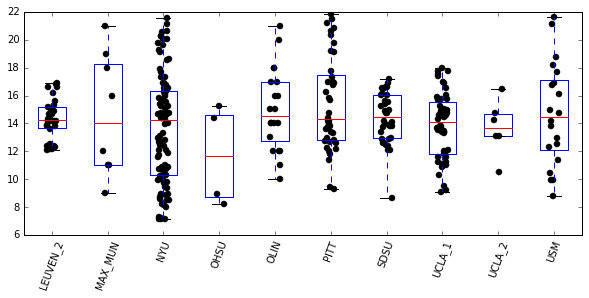

In [22]:
# For anything in the phenotype file
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
spacer = 0.1
# Go through the sites 
grouped_cov = [pgp.get_group(stn)['AGE_AT_SCAN'].values for stn in sites]

for idx, covs in enumerate(grouped_cov):
    stn = sites[idx]
    n_val = len(covs)
    ind = np.ones((n_val,))*idx+1
    jitter = (np.random.random(n_val,)*2-1)*spacer
    ind += jitter
    tmp = ax.plot(ind, covs, 'ko')

tmp = ax.set_xticks(np.arange(len(sites)))
tmp = ax.boxplot(grouped_cov)
tmp = ax.set_xticklabels(sites, rotation=70)

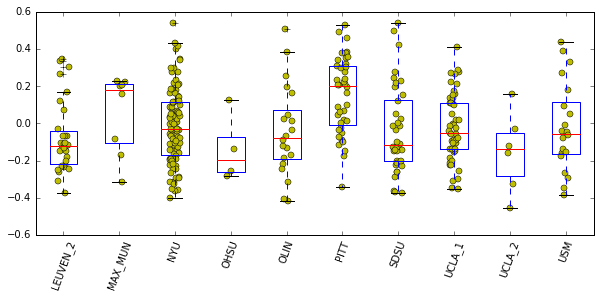

In [36]:
# For the subtype weights
net_id = 1
sbt_id = 2
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
spacer = 0.1
# Go through the sites 
grouped_cov = [weight_store[net_id, sbt_id, (pheno['SITE_ID'] == stn).values] for stn in sites]

for idx, covs in enumerate(grouped_cov):
    stn = sites[idx]
    n_val = len(covs)
    ind = np.ones((n_val,))*idx+1
    jitter = (np.random.random(n_val,)*2-1)*spacer
    ind += jitter
    tmp = ax.plot(ind, covs, 'yo')

tmp = ax.set_xticks(np.arange(len(sites)))
tmp = ax.boxplot(grouped_cov)
tmp = ax.set_xticklabels(sites, rotation=70)

IndexError: index 5 is out of bounds for axis 1 with size 5

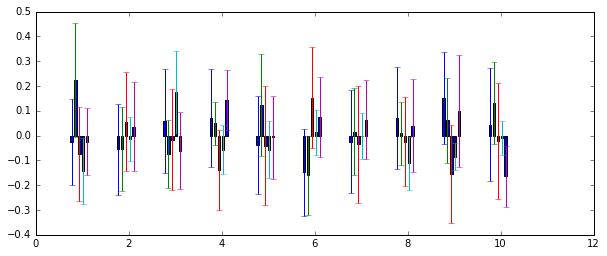

In [39]:
net_id = 1
n_sites = len(sites)
width = 0.5
b_width = width / n_sites
# Get the barplot going so we can compare across networks and subtypes
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
sbt_shift = np.linspace(0,width,scale) - width/2

for sbt_id in np.arange(scale):
    # Go through the sites 
    grouped_avg = np.array([np.mean(weight_store[net_id, sbt_id, (pheno['SITE_ID'] == stn).values]) for stn in sites])
    grouped_std = np.array([np.std(weight_store[net_id, sbt_id, (pheno['SITE_ID'] == stn).values]) for stn in sites])
    
    ind = np.arange(n_sites) + 1 + sbt_shift[sbt_id]
    tmp = ax.bar(ind, grouped_avg, b_width, yerr=grouped_std)

In [ ]:
grouped_av